# *Q1.Solving PDE using various finite difference methods*

Consider the following PDE


\begin{align}
\frac{\partial V}{\partial t}&=\frac{\tilde{\sigma}^2(t,x) x^2}{2}\frac{\partial^2 V}{\partial x^2} + rx\frac{\partial V}{\partial x} -rV,& t>0 \\
V(0,s)&=g(x),& t=0
\end{align}


where we have
\begin{align}
\tilde{\sigma}(t,x) = \sigma(T-t,x) = \left(1+\frac{T-t}{30}\right)\left[0.1 + 0.4\exp\left(-\frac{s}{50}\right)\right]
\end{align}

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as si
from scipy.sparse import diags
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, root, minimize

from scipy.stats import norm


K, r, T = 100, 0.01, 1

*Grid specification*

In [2]:
#Specify grid parameters and set up grids
x_min, x_max = 0, 300
N, M = 1000, 300
dt = T/N
dx = (x_max - x_min)/M
x = np.linspace(x_min, x_max, M+1)
t = np.linspace(0, T, N+1)

# *Explicit scheme*


Let
\begin{align}
a^n_k := a(t_n, x_k) = \frac{\tilde{\sigma}^2(t_n,x_k)x_k^2}{2},\qquad b^n_k := rx_k
\end{align}


Under explicit scheme, we can discretise the above PDE as

\begin{align*}
\frac{V^{n+1}_k-V^n_{k}}{\triangle t}&=a^n_k\frac{V^{n}_{k+1}-2V^n_k+V^n_{k-1}}{\triangle x^2}
+b^n_k \frac{V^{n}_{k+1}-V^n_{k-1}}{2\triangle x}-r V^n_k \\
\implies \quad V^{n+1}_k&=\left(a^n_k\frac{\triangle t}{\triangle x^2}-b^n_k\frac{\triangle t}{2\triangle x}\right)V^{n}_{k-1}+\left(1-2a^n_k\frac{ \triangle t}{\triangle x^2}-r\triangle t \right)V^n_k\\
&\qquad +\left(a^n_k\frac{\triangle t}{\triangle x^2}+b^n_k\frac{\triangle t}{2\triangle x}\right)V^{n}_{k+1}\\
&=A^n_k V^n_{k-1} +(1+B^n_k) V^n_{k}+C^n_k V^n_{k+1}
\end{align*}
for $k=1, 2, ..., M-1$, where
\begin{align}
A^n_k:=a^n_k\frac{\triangle t}{\triangle x^2}-b^n_k\frac{\triangle t}{2\triangle x},\qquad B^n_k:=-2a^n_k\frac{ \triangle t}{\triangle x^2}-r\triangle t ,\qquad C^n_k:=a^n_k\frac{\triangle t}{\triangle x^2}+b^n_k\frac{\triangle t}{2\triangle x}
\end{align}

In [3]:
# Set up the matrices A, B and C, note that A, B and C are time-dependent
def tilde_sigma(t,x):
    return (1+ (T-t[np.newaxis, :])/30) * (0.1 + 0.4* np.exp(-x[:, np.newaxis]/50))

def compute_params(local_volatility_function, t, x):
    #set up a matrix for a^n_k, with each column corresponding to each time step
    local_vol = local_volatility_function(t,x)
    a = 0.5 * local_vol**2 * x[:,np.newaxis]**2 
    b = r * x
    A = a * dt / dx**2  - 0.5 * b[:, None] * dt/ dx
    B = -2 * a * dt / dx**2 - r * dt
    C = a * dt / dx**2  + 0.5 * b[:, None] * dt/ dx
    return (A,B,C)

The matrix L is also time dependent, so we create a 3-D array to hold L at each time step. Note that we choose $n = 0,1,\ldots, N-1$.

In [4]:
# Setup the array L^n 
def compute_L(A,B,C):
    a_diag = np.array([np.concatenate([A[1:-1,j],[0]]) for j in range(N+1)])
    b_diag = np.array([np.concatenate([[0],B[1:-1,j],[0]]) for j in range(N+1)])
    c_diag = np.array([np.concatenate([[0],C[1:-1,j]]) for j in range(N+1)])

    L = np.zeros((N+1, M+1, M+1))
    for i in range(N+1):  
        L[i,:,:] = diags([a_diag[i,:], b_diag[i,:], c_diag[i,:]], [-1, 0, 1]).toarray()
    return (L, a_diag, b_diag, c_diag)



(A_local, B_local, C_local) = compute_params(tilde_sigma, t, x)
(L_local, a_diag_local, b_diag_local, c_diag_local) = compute_L(A_local,B_local,C_local)
I = np.identity(M+1)

The complete recursive algorithm is: 
\begin{align}
V^{n+1}=B^{n+1}((\mathbb{I}+L^n) V^{n})
\end{align}
where $n = 0,1,\ldots,N-1$, and $B^{n+1}(\cdot)$ is an operator which overwrites the first and last entry of the input vector to $\ell^{n+1}_0:=\ell(t_{n+1},x_0)$ and $u^{n+1}_{M}:=u(t_{n+1},x_M)$.

In [5]:
def price_call_explicit_scheme(price_range, time_range, strike_price, L):
    # Initial condition
    v_ex = np.maximum(price_range - strike_price, 0) # call option payoff

    # Iteration of explicit scheme
    for n in range(N):
        v_ex = np.matmul(I+L[n,:,:], v_ex)           # V^{n+1} = (I+L)V^n
        v_ex[0] = 0                           # Boundary operation at x_min
        v_ex[M] = x_max - strike_price*np.exp(-r*time_range[n+1])   # Boundary operation at x_max

    return v_ex

v_ex = price_call_explicit_scheme(x, t, 100, L_local)

# *Fully implicit scheme*

Under the fully implicit scheme, we have
\begin{align*}
 V^{n-1}_k=-A^n_k V^n_{k-1} +(1-B^n_k) V^n_{k}-C^n_k V^n_{k+1}
\end{align*}
for $k=1, 2, ..., M-1$, $n = 1,2,\ldots,N$, where
\begin{align}
A^n_k:=a^n_k\frac{\triangle t}{\triangle x^2}-b^n_k\frac{\triangle t}{2\triangle x},\qquad B^n_k:=-2a^n_k\frac{ \triangle t}{\triangle x^2}-r\triangle t ,\qquad C^n_k:=a^n_k\frac{\triangle t}{\triangle x^2}+b^n_k\frac{\triangle t}{2\triangle x}
\end{align}


The complete recursive algorithm is: 
\begin{align}

(\mathbb{I}-L^{n})V^{n}=B^{n}(V^{n-1}).

\end{align}
where $n = 1,\ldots,N$.

In the fully implicit scheme, we need to make use of the Thomas algorithm to solve the system of equations

In [6]:
# Tridiagional matrix solver. a, b, c are the low, mid and high diagional of the matrix
# d is the constant vector on the RHS
#(copied shamelessly from https://gist.github.com/cbellei/8ab3ab8551b8dfc8b081c518ccd9ada9)
def TDMAsolver(a, b, c, d):

    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]
        	    
    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

In [7]:
def price_option_implicit_scheme(price_range, time_range, a_diag, b_diag, c_diag, final_payoff, lower_boundary, upper_boundary):
    # Initial condition
    v_im = final_payoff(price_range)

    # Iteration of implicit scheme
    for n in range(1,N+1):
        
        d = v_im   # The RHS of the system of equations is V^{n-1}
        d[0] = lower_boundary(price_range[0], time_range[n])  # Boundary operator at x_min
        d[M] = upper_boundary(price_range[M], time_range[n])  # Boundary operator at x_max
        v_im = TDMAsolver(-a_diag[n,:], 1-b_diag[n,:], -c_diag[n,:], d)   # Run the Thomas algorithm to solve for V^n
    return v_im

In [8]:
call_payoff = lambda price_range: np.maximum(price_range - K, 0)
call_lower_boundary = lambda price, time: 0
call_upper_boundary = lambda price, time: x_max - K*np.exp(-r*time)
v_im = price_option_implicit_scheme(x, t, a_diag_local, b_diag_local, c_diag_local, call_payoff, call_lower_boundary, call_upper_boundary)
v_im

array([0.00000000e+00, 2.31275683e-27, 7.16487159e-25, 5.74429093e-23,
       2.11320301e-21, 4.54220468e-20, 6.53501414e-19, 6.87092558e-18,
       5.61363433e-17, 3.72857765e-16, 2.08365125e-15, 1.00625571e-14,
       4.28958215e-14, 1.64200537e-13, 5.72332796e-13, 1.83754002e-12,
       5.48659638e-12, 1.53583847e-11, 4.05813867e-11, 1.01806173e-10,
       2.43701024e-10, 5.59051453e-10, 1.23363593e-09, 2.62716177e-09,
       5.41503568e-09, 1.08301197e-08, 2.10649068e-08, 3.99253878e-08,
       7.38716738e-08, 1.33641443e-07, 2.36735743e-07, 4.11158890e-07,
       7.00952556e-07, 1.17425710e-06, 1.93488023e-06, 3.13866450e-06,
       5.01633133e-06, 7.90495169e-06, 1.22907611e-05, 1.88667088e-05,
       2.86089150e-05, 4.28771040e-05, 6.35450911e-05, 9.31685089e-05,
       1.35198157e-04, 1.94248619e-04, 2.76433070e-04, 3.89776475e-04,
       5.44720554e-04, 7.54734946e-04, 1.03704979e-03, 1.41352547e-03,
       1.91167531e-03, 2.56585654e-03, 3.41864389e-03, 4.52239813e-03,
      

# *Crank-Nicolson scheme*

The general $\theta$-scheme is: 
\begin{align}

(\mathbb{I}-\theta L^{n})V^{n}=B^{n}[(\mathbb{I} + (1-\theta)L^{n-1})V^{n-1})]

\end{align}
where $n = 1,\ldots,N$.

The choice of $\theta = \frac 1 2$ is the Crank-Nicolson scheme, i.e

\begin{align}

(\mathbb{I}-\frac 1 2 L^{n})V^{n}=B^{n}[(\mathbb{I} +\frac 1 2L^{n-1})V^{n-1})]

\end{align}


In [9]:
# Initial condition
v_cn = np.maximum(x - K, 0)

# Iteration of implicit scheme
for n in range(1,N+1):
    
    d = np.matmul(I+ 0.5* L_local[n-1,:,:], v_cn)  # The RHS of the system of equations is V^{n-1}
    d[0] = 0   # Boundary operator at x_min
    d[M] = x_max - K*np.exp(-r*t[n])  # Boundary operator at x_max
    v_cn = TDMAsolver(-0.5*a_diag_local[n,:], 1-0.5*b_diag_local[n,:], -0.5*c_diag_local[n,:], d)   # Run the Thomas algorithm to solve for V^n

Report the call option price at the range of $S_0 \in \{80, 85, \ldots, 120\}$

In [10]:
s_0 = x[80:121:5]
p_ex = v_ex[80:121:5]
p_im = v_im[80:121:5]
p_cn = v_cn[80:121:5]
E_v = pd.DataFrame(np.array([p_ex,p_im,p_cn]).T, columns = ["Explicit","Implicit","Crank-Nicolson"], index = s_0,)

E_v

,Explicit,Implicit,Crank-Nicolson
80.0,0.750545,0.751049,0.750797
85.0,1.474575,1.474503,1.474539
90.0,2.645115,2.644276,2.644695
95.0,4.373712,4.372207,4.372960
100.0,6.727700,6.725912,6.726806
105.0,9.712932,9.711340,9.712136
110.0,13.274460,13.273419,13.273940
115.0,17.313805,17.313419,17.313612
120.0,21.714371,21.714515,21.714443


# *Q2.Computing Implied Volatility*

Part (a)

In [11]:
def blackscholesCall(s0, K, r, T, sigma):
    '''
    #Inputs:
    s0: initial stock price
    K: strike
    sigma: instantaneous volatility
    T: time to maturity
    #Output:
    Black-Scholes Call price
    '''
    sigT = sigma*np.sqrt(T)
    k = np.log(K/s0)
    dp = (1/sigT)*(-k + (r + sigma**2/2)*T)
    dm = dp - sigT
    return s0*(norm.cdf(dp) - np.exp(k-r*T)*norm.cdf(dm))

In [12]:
def black_scholes_call_implied_vol_wrapper(sigma, *args):
    s0, strike, rfr, maturity, option_price_to_match = args
    return blackscholesCall(s0,strike, rfr, maturity, sigma) - option_price_to_match

In [13]:
def impliedVol(s0, K, r, T, option_price_to_match):
    args = (s0, K, r, T, option_price_to_match)
    temp =  fsolve(black_scholes_call_implied_vol_wrapper, x0=0.157, args=args)[0]
    return temp


part (b)

In [14]:
s0 = 100
K_range = np.linspace(70,130,61)

In [15]:
data = []

for strike in K_range:
    call_payoff = lambda price_range: np.maximum(price_range - strike, 0)
    call_lower_boundary = lambda price, time: 0
    call_upper_boundary = lambda price, time: x_max - strike*np.exp(-r*time)

    #This returns a range of prices one for every value of s0 from 0 to 300 therefore we take the 100th value
    call_price = price_option_implicit_scheme(x, t, a_diag_local, b_diag_local, c_diag_local, call_payoff, call_lower_boundary, call_upper_boundary)[100]
    implied_volatility = impliedVol(s0, strike, r, T, call_price)
    data.append([strike, call_price, implied_volatility])

df_local_vol = pd.DataFrame(data,columns=["strike price", "Call Price", "Implied volatility"])
df_local_vol



,strike price,Call Price,Implied volatility
0,70.0,30.801675,0.177624
1,71.0,29.833864,0.176757
2,72.0,28.870015,0.175904
3,73.0,27.910683,0.175065
4,74.0,26.956472,0.174239
...,...,...,...
56,126.0,0.446286,0.144915
57,127.0,0.390025,0.144544
58,128.0,0.340092,0.144178
59,129.0,0.295890,0.143817


In [16]:
blackscholesCall(100, 70, 0.1,1, 0.256693)

36.96681795208588

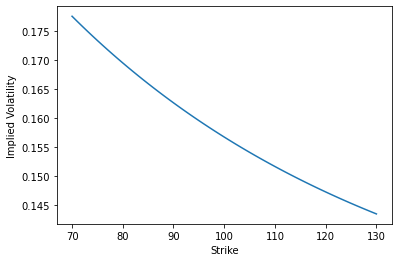

In [17]:
fig1, ax1 = plt.subplots()
ax1.plot(df_local_vol["strike price"], df_local_vol["Implied volatility"])
ax1.set_xlabel('Strike',fontsize = 10)
ax1.set_ylabel("Implied Volatility", fontsize = 10)
plt.savefig("sigma-K1.pdf")
plt.show()


In [18]:
def constant_sigma(t,x):
    return np.ones([M+1, N+1])*0.157

(A,B,C) = compute_params(constant_sigma , t, x)
(L, a_diag, b_diag, c_diag) = compute_L(A,B,C)

In [19]:
data = []

for strike in K_range:
    call_payoff = lambda price_range: np.maximum(price_range - strike, 0)
    call_lower_boundary = lambda price, time: 0
    call_upper_boundary = lambda price, time: x_max - strike*np.exp(-r*time)

    #This returns a range of prices one for every value of s0 from 0 to 300 therefore we take the 100th value
    call_price = price_option_implicit_scheme(x, t, a_diag, b_diag, c_diag, call_payoff, call_lower_boundary, call_upper_boundary)[100]
    implied_volatility = impliedVol(s0, strike, r, T, call_price)
    data.append([strike, call_price, implied_volatility])

df_constant_vol = pd.DataFrame(data,columns=["strike price", "Call Price", "Implied volatility"])
df_constant_vol

,strike price,Call Price,Implied volatility
0,70.0,30.739816,0.157141
1,71.0,29.763163,0.157118
2,72.0,28.789894,0.157097
3,73.0,27.820656,0.157078
4,74.0,26.856169,0.157059
...,...,...,...
56,126.0,0.630059,0.157011
57,127.0,0.565516,0.157018
58,128.0,0.507041,0.157024
59,129.0,0.454137,0.157031


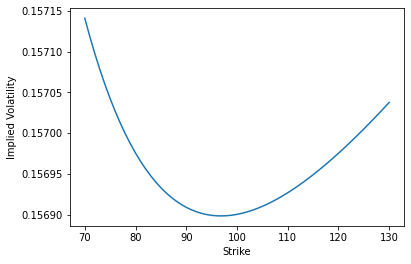

In [20]:
fig2, ax2 = plt.subplots()
ax2.plot(df_constant_vol["strike price"], df_constant_vol["Implied volatility"])
ax2.set_xlabel('Strike',fontsize = 10)
ax2.set_ylabel("Implied Volatility", fontsize = 10)

plt.savefig("sigma-K2.pdf",bbox_inches='tight')
plt.show()



# *Q3.Pricing the Knock-out Barrier Option*

Pricing the put

In [21]:
s0 = 100
k = 100


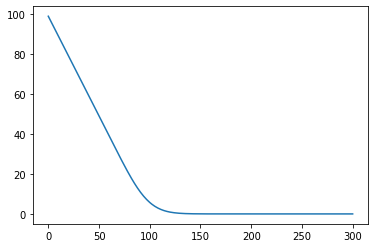

In [22]:
put_payoff = lambda price_range: np.maximum(k-price_range, 0)
put_lower_boundary = lambda price, time: k*np.exp(-r*time)
put_upper_boundary = lambda price, time: 0
put_value = price_option_implicit_scheme(x, t, a_diag, b_diag, c_diag, put_payoff, put_lower_boundary, put_upper_boundary)
plt.plot(put_value)

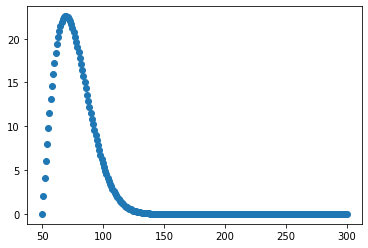

In [23]:
B = 50
x_min = b
M = 301-b
dx = (x_max - x_min)/M
x = np.linspace(x_min, x_max, M+1)
(A_knock_out_local, B_knock_out_local, C_knock_out_local) = compute_params(tilde_sigma, t, x)
(L_knock_out_local, a_diag_knock_out_local, b_diag_knock_out_local, c_diag_knock_out_local) = compute_L(A_knock_out_local,B_knock_out_local,C_knock_out_local)
knock_out_payoff = lambda price_range: np.maximum(k-price_range, 0)
knock_out_lower_boundary = lambda price, time: 0
knock_out_upper_boundary = lambda price, time: 0
knock_out_value = price_option_implicit_scheme(x, t, a_diag_knock_out_local, b_diag_knock_out_local, c_diag_knock_out_local, knock_out_payoff, knock_out_lower_boundary, knock_out_upper_boundary)
plt.scatter(x,knock_out_value)